In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import spacy
import torch
import torch.nn as nn
import torch.utils as utils
import torch.optim as optim
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tokenizers
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
from PIL import Image
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Data

In [3]:
root_dir = '/kaggle/input/flickr-image-dataset/flickr30k_images/'
img_dir = root_dir + 'flickr30k_images'
anno_dir = root_dir + 'results.csv'

In [4]:
# Fixing the results.csv file
with open(anno_dir, 'r') as results, open('/kaggle/working/new_results.csv', 'w') as new_results:
    for line in results:
        if len(line.split('|')) != 3:
            line = line.replace("   ", "|  ")
        new_results.write(line)
        
df = pd.read_csv('/kaggle/working/new_results.csv', sep='|')
df.head()

image_name   comment_number  \
0  1000092795.jpg                0   
1  1000092795.jpg                1   
2  1000092795.jpg                2   
3  1000092795.jpg                3   
4  1000092795.jpg                4   

                                             comment  
0   Two young guys with shaggy hair look at their...  
1   Two young , White males are outside near many...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .

## Vocabulary

In [5]:
spacy_end = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [token.text.lower() for token in spacy_end.tokenizer(text)]

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4 # continue from the 4 special tokens

        # Store words and their frequencies
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                # Adding word to the vocabulary if its frequencies == freq_threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

In [6]:
# Initialize vocabulary
vocab = Vocabulary(5)
vocab.itos[0]

'<PAD>'

In [7]:
# Build vocabulary then check if new words were added
vocab.build_vocabulary(df[' comment'].tolist())
vocab.itos[13]

'standing'

## Dataset

In [8]:
class FlickrDataset(utils.data.Dataset):
    def __init__(self, root_dir, img_caption_df, transform=None, mode='train', vocab=None):
        self.root_dir = root_dir
        self.df = img_caption_df
        self.mode = mode
        self.vocab = vocab
        self.random_seed = 42

        # Split into train/test/val = 0.8/0.1/0.1
        train_df, temp_df = train_test_split(self.df, test_size=0.2, random_state=self.random_seed)

        if self.mode == 'train':
            self.df = train_df
        elif self.mode == 'val':
            val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=self.random_seed)
            self.df = val_df
        else:
            val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=self.random_seed)
            self.df = test_df
            
        self.transform = transform

    def __len__(self):
        return len(self.df)

    

    def __getitem__(self, index):
        row = self.df.iloc[index]
        caption = row[' comment']
        img_id = row['image_name']

        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        # <SOS> This is the caption. <EOS>
        
        return img, torch.tensor(numericalized_caption), img_id

In [9]:
class Collate():
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        # imgs = [item[0].unsqueeze(0) for item in batch]
        # imgs = torch.cat(imgs, dim=0)
        imgs = torch.stack([item[0] for item in batch], dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)

        img_ids = [item[2] for item in batch]
        
        return imgs, targets, img_ids

In [10]:
def get_loader(
    root_folder,
    df,
    transform,
    vocab,
    batch_size=32,
    num_workers=4,
    shuffle=True,
    pin_memory=True,
):

    minimal_transform = transforms.Compose([
        transforms.Resize((299, 299)),  # Ensure consistent size
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    # Create train/val/test datasets
    train_dataset = FlickrDataset(root_folder, df, transform=transform, vocab=vocab)
    val_dataset = FlickrDataset(root_folder, df, transform=minimal_transform, mode='val', vocab=vocab)
    test_dataset = FlickrDataset(root_folder, df, transform=minimal_transform, mode='test', vocab=vocab)
    pad_idx = vocab.stoi["<PAD>"]
    # Create train loader
    train_loader = utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=Collate(pad_idx=pad_idx),
    )

    # Create val loader
    val_loader = utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=Collate(pad_idx=pad_idx),
    )
    
    # Create test loader
    test_loader = utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=1,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=Collate(pad_idx=pad_idx),
    )

    return train_loader, val_loader, test_loader, train_dataset

# Encoder

In [11]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        inception = models.inception_v3(weights='DEFAULT', aux_logits=True)
        modules = list(inception.children())[:-1]   # remove last fc
        # self.cnn = nn.Sequential(*modules)
        self.cnn = nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(3, stride=2),
            inception.Conv2d_3b_1x1,
            inception.Conv2d_4a_3x3,
            nn.MaxPool2d(3, stride=2),
            inception.Mixed_5b,
            inception.Mixed_5c,
            inception.Mixed_5d,
            inception.Mixed_6a,
            inception.Mixed_6b,
            inception.Mixed_6c,
            inception.Mixed_6d,
            inception.Mixed_6e,
            inception.Mixed_7a,
            inception.Mixed_7b,
            inception.Mixed_7c,
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))
        self.linear = nn.Linear(2048, embed_size)

        # Freeze CNN if specified
        for name, param in self.cnn.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.train_CNN

    # This forward will return a 
    def forward(self, images):
        features = self.cnn(images) # (B, 2028, H, W)
        features = self.adaptive_pool(features) # (B, 2048, 8, 8)
        features = features.permute(0, 2, 3, 1) # (B, 8, 8, 2048)
        features = features.view(features.size(0), -1, 2048) # (B, 64, 2048)
        features = self.linear(features) # (B, 64, embed_size)
        return features

In [12]:
# encoder = EncoderCNN(256)
# imgs = torch.randn(32, 3, 299, 299)
# features = encoder(imgs)
# print(features.shape)

# Decoder

In [13]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_attn = nn.Linear(encoder_dim, attention_dim)
        self.decoder_attn = nn.Linear(decoder_dim, attention_dim)
        self.full_attn = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, hidden_state):
        e_attn = self.encoder_attn(encoder_out) # (B, 8x8, embed_size)
        d_attn = self.decoder_attn(hidden_state).unsqueeze(1)
        # d_attn = d_attn.permute(1, 0, 2)
        # print(d_attn.shape)
        attn = self.full_attn(self.relu(e_attn + d_attn)).squeeze(2)  # (B, num_pixels)
        alpha = self.softmax(attn)                             # (B, num_pixels)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (B, encoder_dim)
        return context, alpha

In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        encoder_dim = 256
        attn_dim = 256
        self.num_layers = num_layers
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.attn = Attention(encoder_dim, hidden_size, attn_dim)
        self.lstm = nn.LSTM(embed_size+encoder_dim, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions, teacher_forcing_ratio=0.5):
        # Features shape: (Batch, 8x8, 256)
        # Captions shape: (Batch, Caption's length)
        batch_size = features.size(0)
        num_pixels = features.size(1)
        vocab_size = self.linear.out_features

        embeddings = self.embed(captions) # (B, max_len, embed_size)

        h, c = (torch.zeros(self.num_layers, batch_size, self.lstm.hidden_size, device=features.device),
                torch.zeros(self.num_layers, batch_size, self.lstm.hidden_size, device=features.device))

        outputs = torch.zeros(batch_size, captions.size(1), vocab_size,device=features.device)

        # Iterate though each timestep(word) in the caption
        for t in range(captions.size(1)):
            
            if t == 0 or torch.rand(1, device=features.device) < teacher_forcing_ratio:
                word_embed = embeddings[:, t, :]
            else:
                prev_word = outputs[:, t-1, :].argmax(dim=1)
                word_embed = self.embed(prev_word)

            h_top = h[-1]
            context, alpha = self.attn(features, h_top)

            lstm_input = torch.cat([word_embed, context], dim=1)
            lstm_input = lstm_input.unsqueeze(1)
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))
            
            out = self.linear(self.dropout(lstm_out))
            out = out.squeeze(1)
            
            outputs[:, t, :] = out

        return outputs

# Model

In [15]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image_beam_search(self, image, vocabulary, max_length=50, beam_size=4, start_token="<SOS>", end_token="<EOS>"):
        with torch.no_grad():
            # Encode image → features (1, num_pixels, encoder_dim)
            features = self.encoderCNN(image.unsqueeze(0))
            
            batch_size = features.size(0)
            device = features.device
    
            # Init hidden state
            h, c = (torch.zeros(self.decoderRNN.num_layers, batch_size, self.decoderRNN.lstm.hidden_size, device=device),
                    torch.zeros(self.decoderRNN.num_layers, batch_size, self.decoderRNN.lstm.hidden_size, device=device))
    
            # Start with <SOS>
            start_id = vocabulary.stoi[start_token]
            end_id = vocabulary.stoi[end_token]
    
            # Beam state: (sequence, log_prob, hidden, cell)
            beams = [([start_id], 0.0, h, c)]
    
            for _ in range(max_length):
                candidates = []
                for seq, score, h, c in beams:
                    word = torch.tensor([seq[-1]], device=device)
    
                    if seq[-1] == end_id:
                        # Already ended → keep as is
                        candidates.append((seq, score, h, c))
                        continue
    
                    # Decoder step
                    word_embed = self.decoderRNN.embed(word)
                    h_top = h[-1]
                    context, alpha = self.decoderRNN.attn(features, h_top)
    
                    lstm_input = torch.cat([word_embed, context], dim=1).unsqueeze(1)
                    lstm_out, (h_new, c_new) = self.decoderRNN.lstm(lstm_input, (h, c))
    
                    out = self.decoderRNN.linear(lstm_out.squeeze(1))  # (1, vocab_size)
                    log_probs = torch.log_softmax(out, dim=1)
    
                    # Get top beam_size candidates
                    topk_log_probs, topk_ids = log_probs.topk(beam_size, dim=1)
    
                    for k in range(beam_size):
                        new_seq = seq + [topk_ids[0, k].item()]
                        new_score = score + topk_log_probs[0, k].item()
                        candidates.append((new_seq, new_score, h_new, c_new))
    
                # Keep top beam_size sequences
                beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_size]
    
                # If all beams ended with <EOS>, stop early
                if all(seq[-1] == end_id for seq, _, _, _ in beams):
                    break
    
        # Pick best sequence
        best_seq = beams[0][0]
    
        # Convert to words
        return [vocabulary.itos[idx] for idx in best_seq if idx not in [start_id, end_id]]

    def caption_image(self, image, vocabulary, max_length=50, start_token="<SOS>", end_token="<EOS>"):
        result_caption = []

        with torch.no_grad():
            # Encode image → features (1, num_pixels, encoder_dim)
            features = self.encoderCNN(image.unsqueeze(0))

            batch_size = features.size(0)
            h, c = (torch.zeros(self.decoderRNN.num_layers, batch_size, self.decoderRNN.lstm.hidden_size, device=features.device),
                    torch.zeros(self.decoderRNN.num_layers, batch_size, self.decoderRNN.lstm.hidden_size, device=features.device))

            # Start with <SOS>
            word = torch.tensor([vocabulary.stoi[start_token]], device=features.device)

            for _ in range(max_length):
                word_embed = self.decoderRNN.embed(word)  # (1, embed_size)

                # Apply attention using top hidden state
                h_top = h[-1]
                context, alpha = self.decoderRNN.attn(features, h_top)

                # LSTM step
                lstm_input = torch.cat([word_embed, context], dim=1).unsqueeze(1)
                lstm_out, (h, c) = self.decoderRNN.lstm(lstm_input, (h, c))

                out = self.decoderRNN.linear(lstm_out.squeeze(1))  # (1, vocab_size)
                predicted = out.argmax(1)

                result_caption.append(predicted.item())
                word = predicted  # feed back prediction

                if vocabulary.itos[predicted.item()] == end_token:
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

# Training

In [16]:
def test(model, criterion, loader, device, epoch):
    total_loss = 0
    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])

    # Testing
    model.eval()
    with torch.no_grad():
        
        for imgs, captions, _ in loader:
            imgs = imgs.to(device)
            captions = captions.to(device)
    
            outputs = model(imgs, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:,1:].reshape(-1))
    
            total_loss += loss.item()
            
    print(f"Val Loss: {total_loss / len(loader)}")

    if epoch == 0 or(epoch + 1) % 5 == 0:
        # Display an example every 10 epochs
        img = imgs[0]
        
        generated_caption = model.caption_image_beam_search(img, train_dataset.vocab)
    
        display_img = img.cpu()
        display_img = display_img * std[:, None, None] + mean[:, None, None]
        
        plt.imshow(display_img.permute(1, 2, 0))
        plt.axis('off')
        plt.title(' '.join(generated_caption), fontsize=10)
        plt.show()

In [17]:
def train(params, train_loader, vocab, val_loader=None, test_loader=None, load_model=False, save_model=False):
    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hyperparameters
    embed_size = params['embed_size']
    hidden_size = params['hidden_size']
    vocab_size = params['vocab_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    num_epochs = params['num_epochs']

    # Initialize Model, Loss, Optimizer
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Loading previously trained model
    start_epoch = 0
    if load_model:
        # Get all checkpoints
        checkpoint_files = glob.glob("/kaggle/working/checkpoint_*.pth")
        if not checkpoint_files:
            print("No checkpoint files found in /kaggle/working/. Starting training from scratch.")
        else:
            # Sort checkpoints by epoch number
            checkpoint_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split("_")[-1]))
            # Take the latest one
            latest_checkpoint = checkpoint_files[-1]
            print(f'Loading model from {latest_checkpoint}')
            checkpoint = torch.load(latest_checkpoint)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            loss = checkpoint['loss']
            print(f"Resuming from epoch {start_epoch}, previous loss: {loss}")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss = 0

        # Training on training dataset
        pbar = tqdm(train_loader)
        for imgs, captions, _ in pbar:
            pbar.set_description(f"Epoch {epoch+1}")
            
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:, :-1])

            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:,1:].reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Train Loss: {epoch_loss/len(train_loader)}")

        # Validate training if specified
        if val_loader:
            test(model, criterion, val_loader, device, epoch)

        # Save the model every epoch if save_model is True
        if save_model:
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'loss': epoch_loss/len(train_loader),
            }
            torch.save(checkpoint, f'/kaggle/working/checkpoint_{epoch+1}.pth')
            print(f"Saved checkpoint: /kaggle/working/checkpoint_{epoch+1}.pth")


In [18]:
transform = transforms.Compose([
    transforms.Resize((356, 356)),
    transforms.RandomCrop((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_loader, val_loader, test_loader, train_dataset = get_loader(
    root_folder = img_dir,
    df = df,
    transform = transform,
    vocab = vocab,
    num_workers = 2,
)

In [19]:
params = {
    'embed_size': 256,
    'hidden_size': 512,
    'vocab_size': len(train_dataset.vocab),
    'num_layers': 2,
    'learning_rate': 1e-3,
    'num_epochs': 20,
}

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:02<00:00, 44.8MB/s] 
Epoch 1: 100%|██████████| 3973/3973 [13:14<00:00,  5.00it/s]

Train Loss: 4.280254930565347


Val Loss: 3.836979629048399


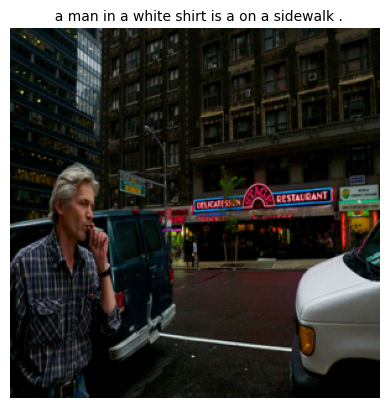

Saved checkpoint: /kaggle/working/checkpoint_1.pth


Epoch 2: 100%|██████████| 3973/3973 [12:32<00:00,  5.28it/s]

Train Loss: 3.847709208449338


Val Loss: 3.6831900257939543
Saved checkpoint: /kaggle/working/checkpoint_2.pth


Epoch 3: 100%|██████████| 3973/3973 [12:42<00:00,  5.21it/s]

Train Loss: 3.723198166248812


Val Loss: 3.583462229197174
Saved checkpoint: /kaggle/working/checkpoint_3.pth


Epoch 4: 100%|██████████| 3973/3973 [13:19<00:00,  4.97it/s]

Train Loss: 3.655185419337563


Val Loss: 3.526934058133745
Saved checkpoint: /kaggle/working/checkpoint_4.pth


Epoch 5: 100%|██████████| 3973/3973 [13:36<00:00,  4.87it/s]

Train Loss: 3.607261398712934


Val Loss: 3.5224855094848264


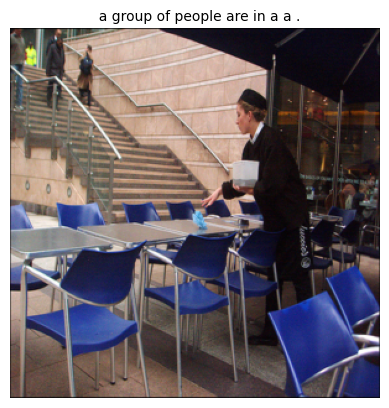

Saved checkpoint: /kaggle/working/checkpoint_5.pth


Epoch 6: 100%|██████████| 3973/3973 [13:24<00:00,  4.94it/s]

Train Loss: 3.5746905378211573


Val Loss: 3.4825784944192746
Saved checkpoint: /kaggle/working/checkpoint_6.pth


Epoch 7: 100%|██████████| 3973/3973 [12:55<00:00,  5.12it/s]

Train Loss: 3.5468842536173506


Val Loss: 3.4622110394644787
Saved checkpoint: /kaggle/working/checkpoint_7.pth


Epoch 8: 100%|██████████| 3973/3973 [12:37<00:00,  5.25it/s]


Train Loss: 3.5223007287962322
Val Loss: 3.460768330265099
Saved checkpoint: /kaggle/working/checkpoint_8.pth


Epoch 9: 100%|██████████| 3973/3973 [12:38<00:00,  5.24it/s]

Train Loss: 3.5041876649964583


Val Loss: 3.4262599215900873
Saved checkpoint: /kaggle/working/checkpoint_9.pth


Epoch 10: 100%|██████████| 3973/3973 [12:35<00:00,  5.26it/s]

Train Loss: 3.488480209134071


Val Loss: 3.441888771306581


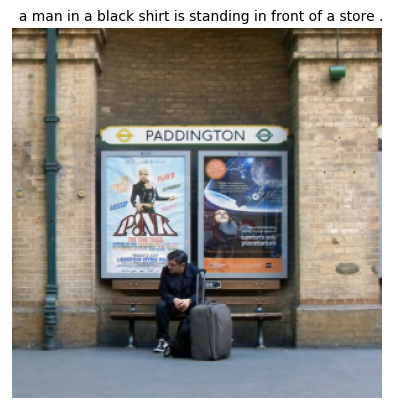

Saved checkpoint: /kaggle/working/checkpoint_10.pth


Epoch 11: 100%|██████████| 3973/3973 [12:40<00:00,  5.22it/s]

Train Loss: 3.4774784664348006


Val Loss: 3.4016427485276037
Saved checkpoint: /kaggle/working/checkpoint_11.pth


Epoch 12: 100%|██████████| 3973/3973 [12:44<00:00,  5.20it/s]

Train Loss: 3.4633640215614716


Val Loss: 3.4363672819655666
Saved checkpoint: /kaggle/working/checkpoint_12.pth


Epoch 13: 100%|██████████| 3973/3973 [12:43<00:00,  5.20it/s]


Train Loss: 3.4454592680288987
Val Loss: 3.382912682815337
Saved checkpoint: /kaggle/working/checkpoint_13.pth


Epoch 14: 100%|██████████| 3973/3973 [12:33<00:00,  5.27it/s]

Train Loss: 3.4475429065876213


Val Loss: 3.3962858289300315
Saved checkpoint: /kaggle/working/checkpoint_14.pth


Epoch 15: 100%|██████████| 3973/3973 [12:59<00:00,  5.09it/s]

Train Loss: 3.4383781324727933


Val Loss: 3.4044707392303035


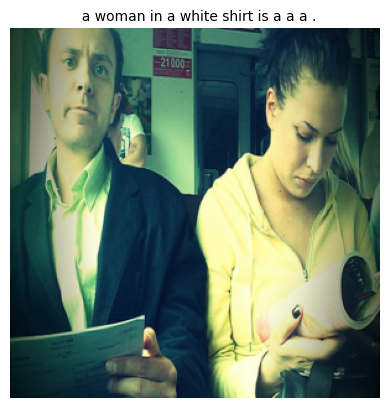

Saved checkpoint: /kaggle/working/checkpoint_15.pth


Epoch 16: 100%|██████████| 3973/3973 [12:52<00:00,  5.14it/s]

Train Loss: 3.433410008308301


Val Loss: 3.381922310266936
Saved checkpoint: /kaggle/working/checkpoint_16.pth


Epoch 17: 100%|██████████| 3973/3973 [12:52<00:00,  5.14it/s]

Train Loss: 3.424814663274205


Val Loss: 3.3817200339296214
Saved checkpoint: /kaggle/working/checkpoint_17.pth


Epoch 18: 100%|██████████| 3973/3973 [13:00<00:00,  5.09it/s]

Train Loss: 3.41205607719575


Val Loss: 3.3853821437843368
Saved checkpoint: /kaggle/working/checkpoint_18.pth


Epoch 19: 100%|██████████| 3973/3973 [12:54<00:00,  5.13it/s]


Train Loss: 3.4106773104140777
Val Loss: 3.3787133938349947
Saved checkpoint: /kaggle/working/checkpoint_19.pth


Epoch 20: 100%|██████████| 3973/3973 [12:19<00:00,  5.37it/s]

Train Loss: 3.406439190153328


Val Loss: 3.389957132473798


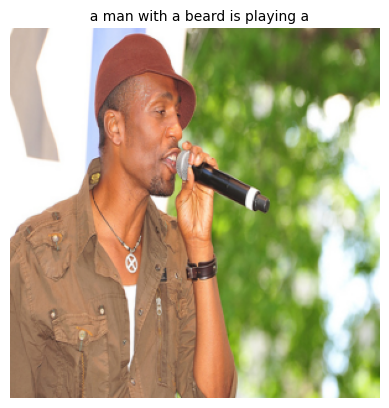

Saved checkpoint: /kaggle/working/checkpoint_20.pth


In [20]:
train(params, train_loader, train_dataset.vocab, val_loader, test_loader, load_model=False, save_model=True)

# Testing

In [21]:
# A captions dictionary to get reference captions for BLEU score
class CaptionsDict():
    def __init__(self):
        self.captions_dict = {}

    def get_captions_dict(self, captions_file):
        with open(captions_file) as f:
            next(f)
            for line in f:
                
                img_id, captions = line.split('| ', 1)
                captions = captions[3:-2]
                
                if img_id in self.captions_dict.keys():
                    self.captions_dict[img_id].append(captions)
                else:
                    self.captions_dict[img_id] = [captions]

    def get_reference_captions(self, img_id):
        return self.captions_dict[img_id]

Reference captions: [
Two children are asleep in a two-child stroller on the sidewalk 
Two children sleeping in an unattended double stroller 
A baby and a toddler both rest in a twin stroller 
Two young children sleep peacefully in a stroller 
Two children sleeping in a stroller 
]
Generated caption:   a little girl in a pink shirt is a a a a .


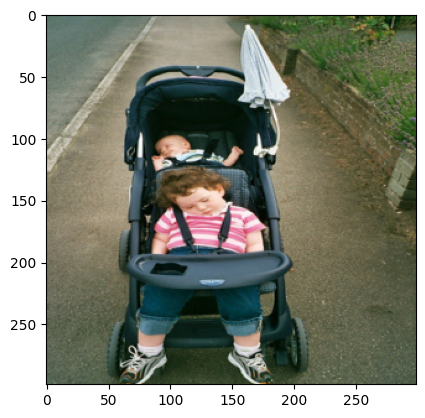

Reference captions: [
A group of construction workers are attempting to pull a cover onto a framework 
Six construction workers are pulling a roof up with ropes 
Construction workers are putting together a white canopy 
Construction workers putting up a building together 
Workers erect a pavilion for an event in the park 
]
Generated caption:   a man in a blue shirt is walking down the street .


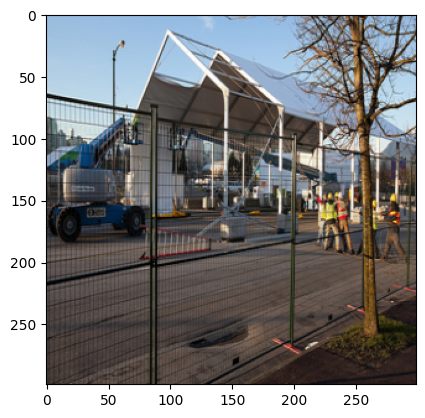

Reference captions: [
A brown a dog and a black dog in the edge of the ocean with a wave under them boats are on the water in the background 
Two dogs , one brown and the other black , play in the surf in the shallow ocean water 
Two dogs stand back to back in the ocean 
Two dogs playing in the waves 
two dogs play in the water 
]
Generated caption:   two dogs run through the water .


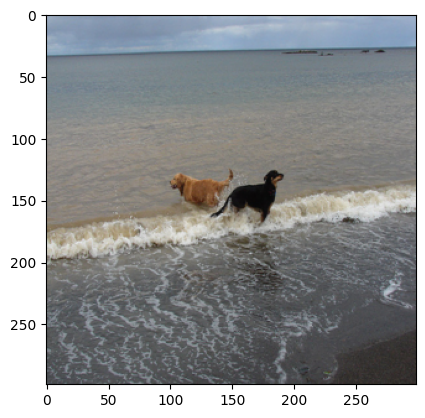

Reference captions: [
A man in a white uniform rides a motocross bike down a forest trail 
A person on a bike and wearing a helmet rides through a wooded area 
A dirt biker rounding a bend on a downhill course 
The motorbiker is biking on an off road trai
BMX rider , riding downhill on forest path 
]
Generated caption:   a person is a a a a a .


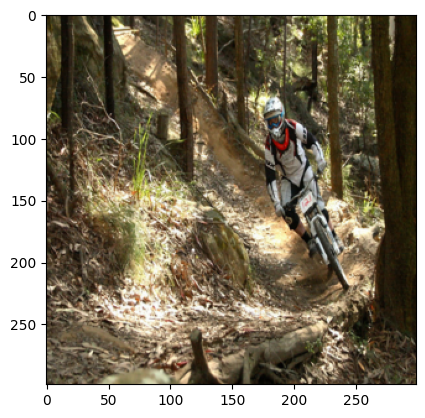

Reference captions: [
a black dog with a blue tag running on a beac
The brown dog is running across the sand 
A brown dog runs down the sandy beach 
Black dog running across sand 
A brown dog runs in the sand 
]
Generated caption:   a black dog running through the water .


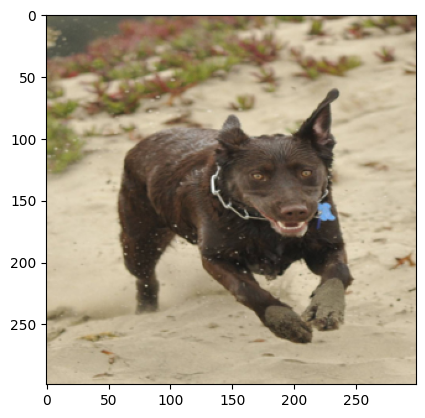

Reference captions: [
An elderly couple in heavy coats are looking at black and white photos displayed on a wall 
A couple dressed in winter coats admire framed photos on a white wall 
Two people in coats examine black and white photos in a gallery 
Two men are looking at some old photographs hanging on a wall 
Couple looking at photos in a gallery 
]
Generated caption:   a man and a woman are a a a .


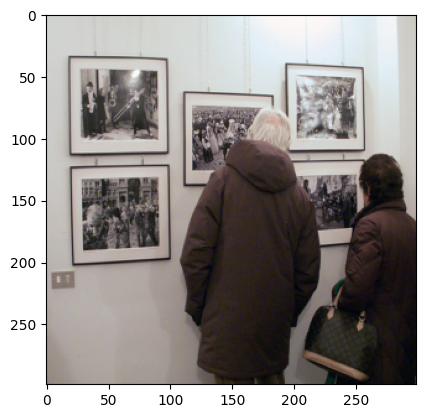

Reference captions: [
A shirtless man jumping off a large concrete structure into a river with his friends watching from the structure 
A man wearing swimming trunks jumps off a concrete platform into a large body of water 
A shirtless man leaps into the water as other people watch 
A man is jumping off complex into a body of water 
A man jumping into the water 
]
Generated caption:   a brown dog is into the water .


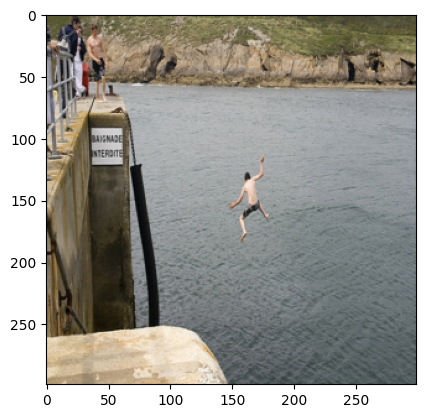

Reference captions: [
A couple is sitting on some chairs in the winter in what looks to be a park 
Two people dressed for cold weather sit in chairs next to a body of water 
A man and a woman in winter clothing sitting in chairs by a lake 
Two people are sitting in the park , on a cold winter day 
two people sitting at a bar 
]
Generated caption:   a man and a woman are on a bench .


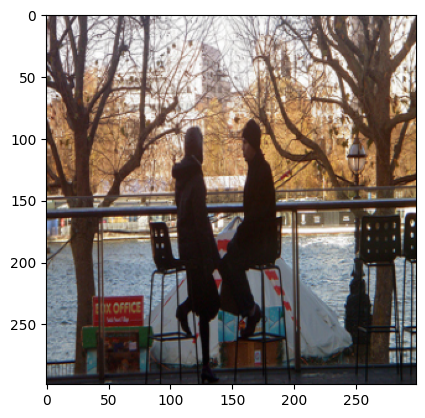

Reference captions: [
A rodeo rider gets tossed up into the air by a black bull as fellow cowboys look on 
A man is roping a bull in a rodeo while others in cowboy hats watch 
The man in black is flying off the full in front of a red fence 
A man is up in the air with one hand on a bull 
man getting thrown in the air while bull ridin
]
Generated caption:   a man wearing a cowboy hat is riding a horse .


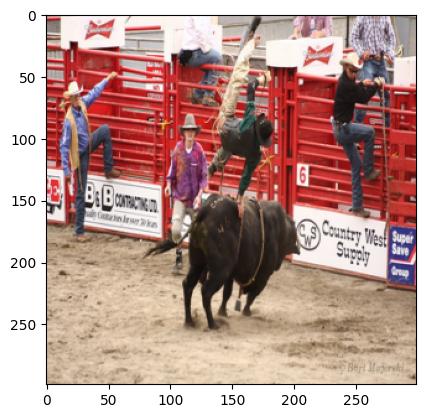

Reference captions: [
A man on the street standing in front of an " Alessi " sign is kneeling , tuning his guitar 
A man with a brown coat and blue headscarf is kneeling and tuning a guitar 
a man playing a guitar outside a building with colorful decoration
A man with a bandanna on the side of the road plays his guitar 
The young man is tuning his guitar 
]
Generated caption:   a man is playing a guitar .


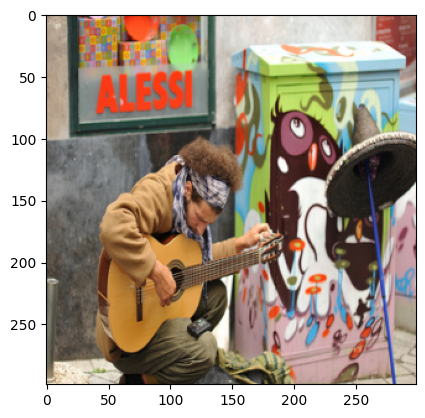

Reference captions: [
The winners 1st , 2nd , and 3rd of a event posing for a picture each holding flowers 
The men who won first , second , and third place of a bicycle race 
3 Olympic winners posing for a photo on an advertised backgroun
Three athletes holding bouquets stand on the victory podium 
Three men accepting an award 
]
Generated caption:   a group of people are standing in front of a sign .


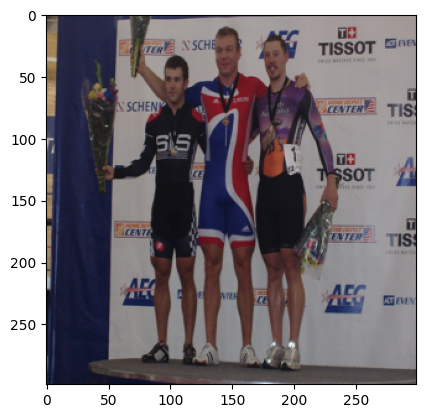

BLEU Score: 0.5755649290879822


In [22]:
# Parameters
embed_size = params['embed_size']
hidden_size = params['hidden_size']
vocab_size = params['vocab_size']
num_layers = params['num_layers']

mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])
captions_dict = CaptionsDict()
captions_dict.get_captions_dict("/kaggle/working/new_results.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers)

# Load model
checkpoint = torch.load('/kaggle/working/checkpoint_20.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
i = 0

model.eval()
with torch.no_grad():
    
    # Testing using BLEU score
    reference_captions = []
    generated_captions = []

    for imgs, captions, img_id in test_loader:
        
        # Using only the first image since the test loader's batch size is 1
        img = imgs[0].to(device)
        
        generated_caption = model.caption_image_beam_search(img, train_dataset.vocab)
        generated_caption = ' '.join(generated_caption)
        
        reference_captions.append(captions_dict.get_reference_captions(img_id[0]))
        generated_captions.append(generated_caption)

        if i % 1500 == 0:
            print("Reference captions: [")
            for r_cap in captions_dict.get_reference_captions(img_id[0]):
                print(r_cap, end='\n')
            print("]\nGenerated caption:", generated_caption)
            display_img = img.cpu()
            display_img = display_img * std[:, None, None] + mean[:, None, None]
            plt.imshow(display_img.permute(1, 2, 0))
            plt.show()

        i += 1

# Calculating BLEU Score
smooth_fn = SmoothingFunction().method4
bleu = corpus_bleu(reference_captions, generated_captions, smoothing_function=smooth_fn)
print(f"BLEU Score: {bleu}")

# Inference

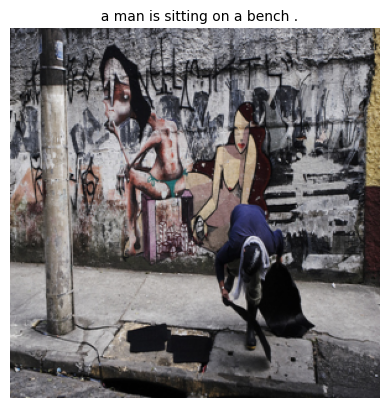

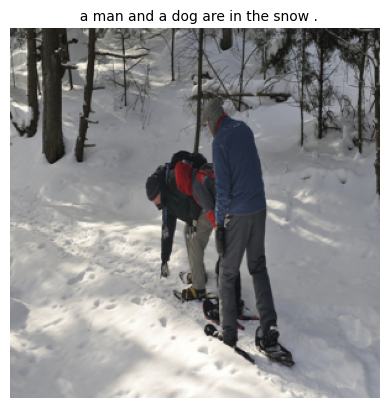

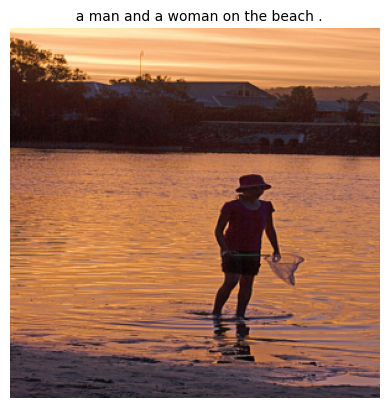

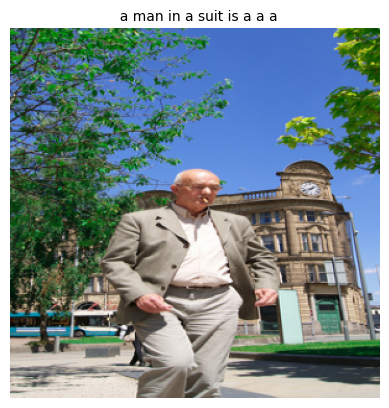

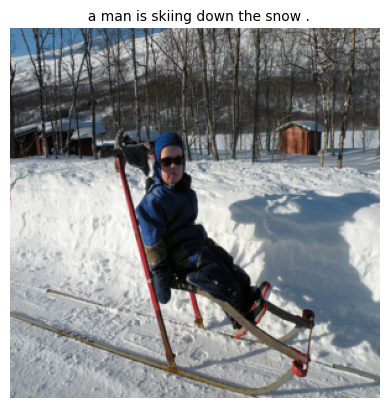

In [23]:
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

for i, (imgs, captions, img_id) in enumerate(test_loader):
    if i < 5:
        img = imgs[0].to(device)
    
        generated_caption = model.caption_image_beam_search(img, train_dataset.vocab)
    
        display_img = img.cpu()
        display_img = display_img * std[:, None, None] + mean[:, None, None]
        
        plt.imshow(display_img.permute(1, 2, 0))
        plt.axis('off')
        plt.title(' '.join(generated_caption), fontsize=10)
        plt.show()
    
    else:
        break